# NLP Disaster Tweets Mini-Project

## Introduction

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring TwitterIn this mini-project, we are looking at Twitter tweets. Our goal is to be able to classify tweets to determine if a given tweet is about a real disaster or not. In this notebook we will be:
1. Describing the challenge problem and dataset
2. Doing Exploratory Data Analysis (EDA)
3. Describing the Deep Learning Model Architecture
4. Analyzing Results
5. Talking about learnings and takeaways

First, we'll import some of the import some of the common libraries we need such as numpy, pandas and tensorflow.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

## Dataset and the Problem

Let's import the traning data. As seen below, there are 7613 tweets in the 'text column. The target column classifies the tweet as one about a disaster or not. A target of 1 means the tweet is about a disaster. A target of 0 means the tweet is not about a disaster. Our goal is to train deep learning models on the training data to be able to predect if a future tweet is about a real diaster or not. Included in the data are columns about the location of the tweet and any possible keywords. Not all tweets include keywords and/or a location. For this mini-project we will not be using the keyword or location column.

In [187]:
train = pd.read_csv('https://raw.githubusercontent.com/kech3776/NLP-Disaster-Tweets/main/test.csv')

In [188]:
train.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Exploratory Data Analysis

### Initial Look

Let's take a close look at the contents of the data. We see that of the 7613 tweets, there are 4342 tweets that are classified as not a disaster tweet and 3271 tweets that are classified as a disaster tweet. As a percentage, that is 57% that are not considered disaster tweets and 43% that are considered disaster tweets.

In [10]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

[Text(0.5, 1.0, 'Target Counts')]

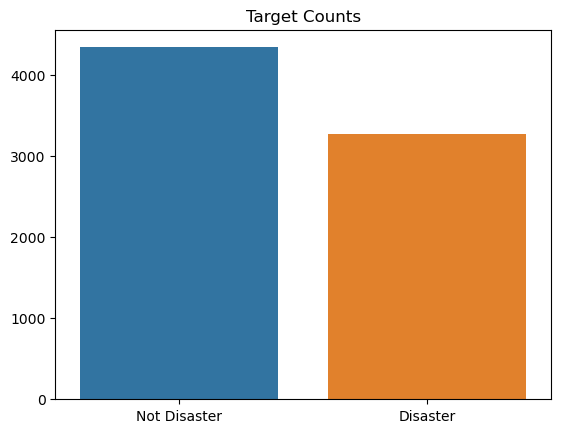

In [11]:
label = ['Not Disaster', 'Disaster']
freq = [4342,3271]
sns.barplot(x = label, y = freq).set(title = 'Target Counts')

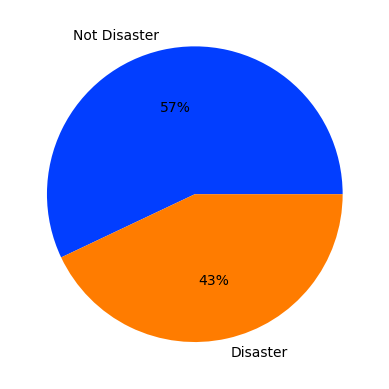

In [12]:
colors = sns.color_palette('bright')[0:5]
plt.pie(freq, labels = label, colors = colors, autopct='%.0f%%')
plt.show()

### Cleaning Data

We have now seen some of the preliminary data. Let's start to clean that data into something we can use. Below, we have a method that cleans the text data into something that we can use. For this process, we will be using the nltk library.
The process goes:
1. Remove any links in the tweet
2. Make sure the tweet is all lowercase
3. Remove all punctuation
4. Tokenize the text
5. Remove any numbers in the tweet
6. Remove any stop words in the tweet
7. Remove any non-ASCII characters
8. Lemmatize any verbs still present to reduce the number of similar words i.e. fish, fishing, fished

In [13]:
import string, re, unicodedata
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def remove_non_ascii(words):
    #Remove non-ASCII characters from list of tokenized words
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def lemmatize_verbs(words):
    #Lemmatize verbs in list of tokenized words
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def clean_data(df, col):
    df_set = []
    df_set_length = []
    for i in range(len(df)):
        text = df[col][i]
        text = re.sub(r"http\S+", "", text)  #remove links
        text = text.lower() #make words all lowercase
        text_p = "".join([char for char in text if char not in string.punctuation]) #remove punctuation
        words = word_tokenize(text_p) #tokenize 
        words = [word for word in words if word.isalpha()] #remove numbers
        stop_words = stopwords.words('english') 
        filtered_words = [word for word in words if word not in stop_words] #remove stopwords
        filtered_words = remove_non_ascii(filtered_words) # Remove any non-ASCII characters
        stemmed = lemmatize_verbs(filtered_words) # Lemmatize verbs
        
        df_set.append(stemmed)
        df_set_length.append(len(stemmed))
    df['Tokenized'] = df_set
    df['SetLength'] = df_set_length
    return df

In [15]:
train_clean = clean_data(train, 'text')
train_clean = train_clean.drop(columns = ['keyword', 'location'])
train_clean.head()

,id,text,target,Tokenized,SetLength
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...",7
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",7
2,5,All residents asked to 'shelter in place' are ...,1,"[residents, ask, shelter, place, notify, offic...",11
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...",6
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[get, send, photo, ruby, alaska, smoke, wildfi...",9


Here is an example of a tweet before it has been cleaned and after it has been cleaned.

In [16]:
print(train_clean['text'][1020])
print(train_clean['Tokenized'][1020])

HOBO Hobo Vintage Shira Convertible BÛ_ $238.00 #bestseller http://t.co/0LLwuqn8vg
['hobo', 'hobo', 'vintage', 'shira', 'convertible', 'bestseller']


### More Tweet Distribution Insights

Now let's look at the lengths of the tokenized tweets. We see that the median of the dataset is 9 words the tweet with the highest number of words is 23. As for the histogram, the distribution of lengths looks to be mostly normal with a slight right skew.

In [23]:
print('median', train_clean['SetLength'].median())
print('max:', train_clean['SetLength'].max())

median 9.0
max: 23


<AxesSubplot: xlabel='SetLength', ylabel='Count'>

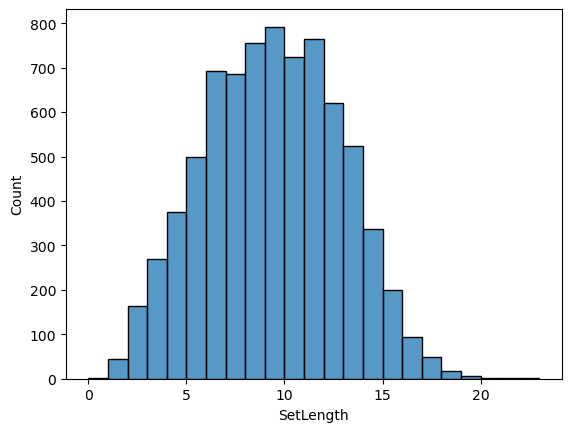

In [24]:
sns.histplot(data = train_clean, x = 'SetLength', binwidth = 1)

We can also look at the frequency of any words that are used. Below, we see that there are 14229 unique words that are used from all of the tweets. The five most common are 'get', 'like', 'fire', 'im' and 'amp'. 

In [30]:
from collections import Counter

def count_words(df):
    count = Counter()
    for text in df['Tokenized'].values:
        for word in text:
            count[word] += 1
    return count

word_freq = count_words(train_clean)
print(len(word_freq))
print(word_freq.most_common(5))

14229
[('get', 440), ('like', 392), ('fire', 357), ('im', 299), ('amp', 298)]


We now know some of the most frequent words used in these tweets but what are the most common words used for tweets depending on if the tweet is about a real disaster or not?

Disaster
7423


[Text(0.5, 1.0, 'Disaster')]

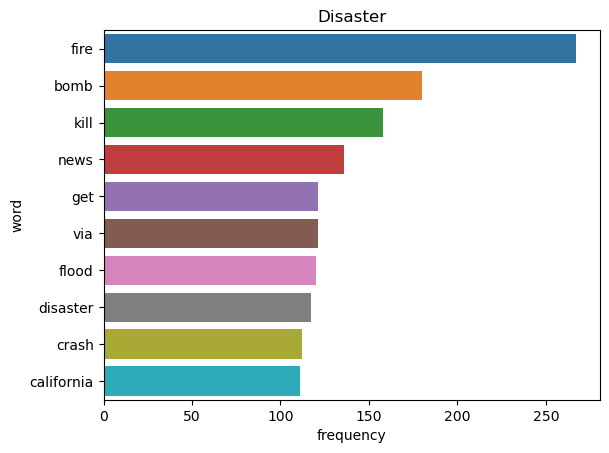

In [44]:
disaster = train_clean[train_clean['target'] == 1]
no_disaster = train_clean[train_clean['target'] == 0]

disaster_freq = count_words(disaster)
no_disaster_freq = count_words(no_disaster)

print('Disaster')
print(len(disaster_freq))
most_freq_disaster = disaster_freq.most_common(10)
most_freq_disaster = pd.DataFrame(most_freq_disaster, columns = ['word', 'frequency'])
sns.barplot(data = most_freq_disaster, y = most_freq_disaster['word'], 
            x = most_freq_disaster['frequency'], errorbar = None ).set(title = 'Disaster')



Not Disaster
10136


[Text(0.5, 1.0, 'Not Disaster')]

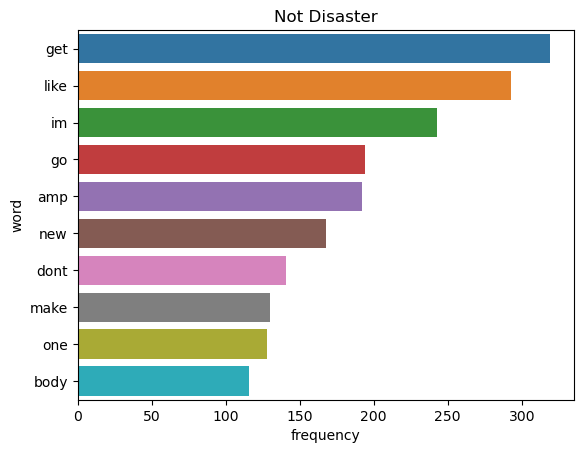

In [46]:
print('Not Disaster')
print(len(no_disaster_freq))
most_freq_no_disaster = no_disaster_freq.most_common(10)
most_freq_no_disaster = pd.DataFrame(most_freq_no_disaster, columns = ['word', 'frequency'])
sns.barplot(data = most_freq_no_disaster, y = most_freq_no_disaster['word'], 
            x = most_freq_no_disaster['frequency'], errorbar = None ).set(title = 'Not Disaster')

From the charts above, we see that get is the most common in tweets that are not disaster tweets. However, they are also top 5 in frequency in disaster tweets. The tweets that are disaster tweets have some obvious terms such as fire, bomb, kill and flood. Interstingly enough 'california' ranks in the top 10. It might be that California has had a fair share of natural disasters. The top words for tweets that aren't about disasters don't seem to have any pattern  going on. The terms look like generic terms such as go, new, don't, and like.

## Deep Learning Model Architecture

Now we transform the list of words into numbers so the deep learning model can use that data. First, we will split the data into a training dataset and a validation dataset. The training dataset will contain 80% of the original dataset and the validation dataset will contain the other 20%.

In [48]:
from sklearn.model_selection import train_test_split
X = train_clean['Tokenized'].to_numpy()
y = train_clean['target'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 101)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6090,) (6090,)
(1523,) (1523,)


Next, we will use Tokenizer from the keras library to create a dictionary of all the unique words. Each unique word will be assigned a number. Below, you can see that 'get' is assigned to 1, 'like' is assigned to 2 and so on. 

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = len(word_freq))
tokenizer.fit_on_texts(X_train)

In [128]:
import itertools
print(len(tokenizer.word_index))
dict(itertools.islice(tokenizer.word_index.items(), 10))

12352


{'get': 1,
 'like': 2,
 'fire': 3,
 'amp': 4,
 'im': 5,
 'go': 6,
 'bomb': 7,
 'new': 8,
 'via': 9,
 'one': 10}

Using the dictionary will give us the tweets in number form. An example of a tweet is shown below as words and as numbers

In [58]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [64]:
print(X_train[2000])
print(X_train_seq[2000])

['steve', 'fire', 'something', 'else', 'california', 'tinderbox', 'clown', 'set', 'hood', 'ablaze']
[1949, 3, 337, 754, 44, 7206, 3938, 128, 3860, 464]


When processing sequence data, it is very common for individual samples to have different lengths. However, the input data for a deep learning model must be a single tensor. Tweets that are shorter than the longest item need to be padded with some placeholder value. The longest tweet is 23 words so we will add padding to the end of all tweets that have under 23 words. Another example is shown below before padding and after padding.

In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_seq, maxlen = 23, padding = "post", truncating = "post")
X_val_padded = pad_sequences(X_val_seq, maxlen = 23, padding = "post", truncating = "post")
print(X_train_padded.shape, X_val_padded.shape)

(6090, 23) (1523, 23)


In [70]:
print('unpadded', X_train_seq[56])
print('padded', X_train_padded[56])

unpadded [4703, 4704, 3156, 178, 171, 3]
padded [4703 4704 3156  178  171    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


### LSTM Model

The first model we will be creating will be the LSTM model. LSTM is a Long-Short Term Memory model which is a type of Recurrent Neural Network. LSTM is made up of three gates which are the input gate, forget gate and output gate. A LSTM model works well with the the data we have since the neural network has "memory" can past data can influence future decision making. In this case, words in the beginning of the tweet influence words from later on in the tweet. 

For this LSTM model, I started with an Embedding layer. The Embedding layer is to help the neural netword understand the inputs given. The length of tokenizer.word_index is all the possible words that can appear while the imput length is the length of each tweet with padding. A bidirectional LSTM layer is added afterwards. Since order matters in a tweet, a bidirectional LSTM layer works better than just an LSTM layer. Finally, there is a Dense layer with a sigmoid activation to determine if yes the tweet is about a disaster or not it is not about a disaster.

In this model, overfitting seemed to be a major problem. As seen in the charts below, both the validation loss and validation accuracy plateaued while the training accuracy and loss continued to increase. It's not unusual for NLP models to have problems with overfitting since there are a myriad of possible words that are used. Some of the hyperparameter modifications that were effective were to add a dropout after the LSTM layer and reducing the learning rate. Other methods that were helpful were to reduce the number of layers. Having the bare minimum of layers helped against overfitting. Finally, having an early stopping callback helped the model end early if the validation loss began to creep up. In this model, we can see that the training stopped at 8 epochs even though the model was set fo 10 epochs. One surprising thing that did not work was adding a recurring dropout to the LSTM layer. It not only made training a lot slower, but it did not help in reducing overfitting not did it increase the validation accuracy.

In [182]:
import keras
from keras import layers

lstm_model = keras.models.Sequential()
lstm_model.add(layers.Embedding(len(tokenizer.word_index),32,input_length = 23))
lstm_model.add(layers.Bidirectional(layers.LSTM(23, dropout = 0.2)))
lstm_model.add(layers.Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

lstm_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

lstm_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 23, 32)            395264    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 46)                10304     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 47        
Total params: 405,615
Trainable params: 405,615
Non-trainable params: 0
_________________________________________________________________


In [183]:
epoch = 10

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
run_model_lstm = lstm_model.fit(X_train_padded, y_train, epochs = epoch, 
                                validation_data = (X_val_padded, y_val), verbose = 1, 
                                callbacks = [es_callback])

Epoch 1/10
191/191 [==============================] - 8s 15ms/step - loss: 0.6884 - accuracy: 0.5389 - val_loss: 0.6772 - val_accuracy: 0.5857
Epoch 2/10
191/191 [==============================] - 2s 11ms/step - loss: 0.6753 - accuracy: 0.5665 - val_loss: 0.6627 - val_accuracy: 0.5857
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6497 - accuracy: 0.5821 - val_loss: 0.6258 - val_accuracy: 0.6323
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5680 - accuracy: 0.7158 - val_loss: 0.5098 - val_accuracy: 0.7597
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3711 - accuracy: 0.8466 - val_loss: 0.4685 - val_accuracy: 0.7945
Epoch 6/10
191/191 [==============================] - 2s 11ms/step - loss: 0.2850 - accuracy: 0.8874 - val_loss: 0.4827 - val_accuracy: 0.7905
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2348 - accuracy: 0.9120 - val_loss: 0.5046 - val_accuracy: 0.7794

After training the model, we get an training accuracy of 0.9286 and a validation accuracy of 0.7774. With a training loss of 0.1995 and a validation loss of 0.5332. Now let's look at the accuracy and loss by epoch.

In [184]:
#organize accuracy and loss data into a dataframe
epoch_lst = list(range(1, epoch + 1))
accuracy = pd.DataFrame(list(zip(epoch_lst, run_model_lstm.history['accuracy'],
                        run_model_lstm.history['val_accuracy'])),
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])
loss = pd.DataFrame(list(zip(epoch_lst, run_model_lstm.history['loss'],
                        run_model_lstm.history['val_loss'])),
                        columns = ['Epoch','Loss', 'Val_Loss'])

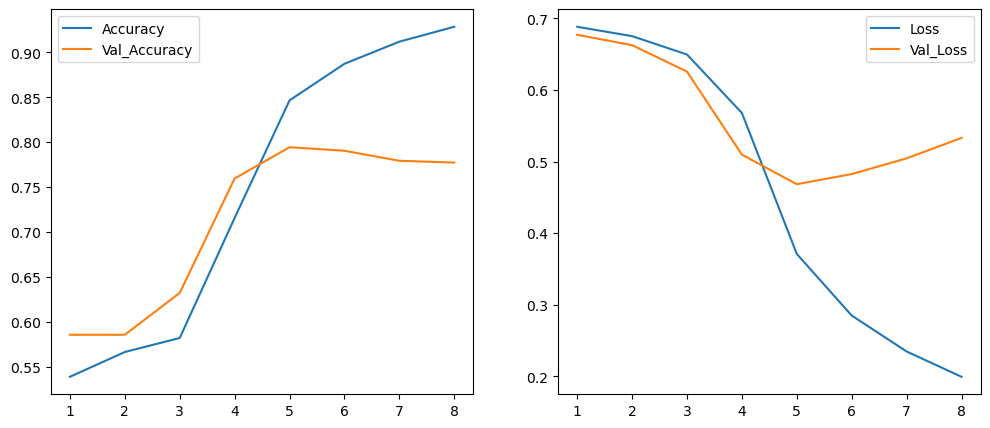

In [185]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy['Epoch'],accuracy['Accuracy'])
ax1.plot(accuracy['Epoch'],accuracy['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss['Epoch'], loss['Loss'])
ax2.plot(loss['Epoch'], loss['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])

### GRU Model

The second model we will use is the GRU model. The GRU model is similar to the LSTM model but has one less gate. It contains an update gate and a reset gate. The update gate acts similarly to the forget and imput gate of an LSTM which decides which imformation to keep and forget. The reset gate decides how much information to forget.

Like the LSTM model, there is an Embidding layer to help the neural netword understand the inputs given since the input is the same as the prior model. Next there is a bidirectional GRU layer followed by a Dense layer with a sigmoid activation. A bidirectional GRU layer works well the same reason as why a bidirectional LSTM model worked well above.

For the GRU model, I experienced much of the same problems with overfitting. Having a dropout and reducing the learning rate helped. Keeping the model simple with minimal layers also helped reduce overfitting. Adding multiple GRU layers did not help much in increasing validation accuracy but increased validation loss. Even though there was overfitting, looking at the loss chart, we see that there is less overfitting in the GRU model than the LSTM model.

In [138]:
gru_model = keras.models.Sequential()
gru_model.add(layers.Embedding(len(tokenizer.word_index),32,input_length = 23))
gru_model.add(layers.Bidirectional(layers.GRU(23, dropout = 0.2)))
gru_model.add(layers.Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

gru_model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
gru_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 23, 32)            395264    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 46)                7866      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 47        
Total params: 403,177
Trainable params: 403,177
Non-trainable params: 0
_________________________________________________________________


In [139]:
epoch = 10 
run_model_gru = gru_model.fit(X_train_padded, y_train, epochs = epoch, 
                              validation_data = (X_val_padded, y_val), verbose = 1)

Epoch 1/10
191/191 [==============================] - 6s 14ms/step - loss: 0.6879 - accuracy: 0.5581 - val_loss: 0.6796 - val_accuracy: 0.5857
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6786 - accuracy: 0.5665 - val_loss: 0.6686 - val_accuracy: 0.5857
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6578 - accuracy: 0.5729 - val_loss: 0.6302 - val_accuracy: 0.6139
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5735 - accuracy: 0.7046 - val_loss: 0.5370 - val_accuracy: 0.7334
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4477 - accuracy: 0.8309 - val_loss: 0.4799 - val_accuracy: 0.7781
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.3630 - accuracy: 0.8649 - val_loss: 0.4680 - val_accuracy: 0.7820
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3147 - accuracy: 0.8821 - val_loss: 0.4829 - val_accuracy: 0.7859
E

After training the model, we get an training accuracy of 0.9179 and a validation accuracy of 0.7814. With a training loss of 0.2168 and a validation loss of 0.5081. Now let's look at the accuracy and loss by epoch.

In [178]:
#organize accuracy and loss data into a dataframe
epoch_lst = list(range(1, epoch + 1))
accuracy = pd.DataFrame(list(zip(epoch_lst, run_model_gru.history['accuracy'],
                        run_model_gru.history['val_accuracy'])),
                        columns = ['Epoch','Accuracy', 'Val_Accuracy'])
loss = pd.DataFrame(list(zip(epoch_lst, run_model_gru.history['loss'],
                        run_model_gru.history['val_loss'])),
                        columns = ['Epoch','Loss', 'Val_Loss'])

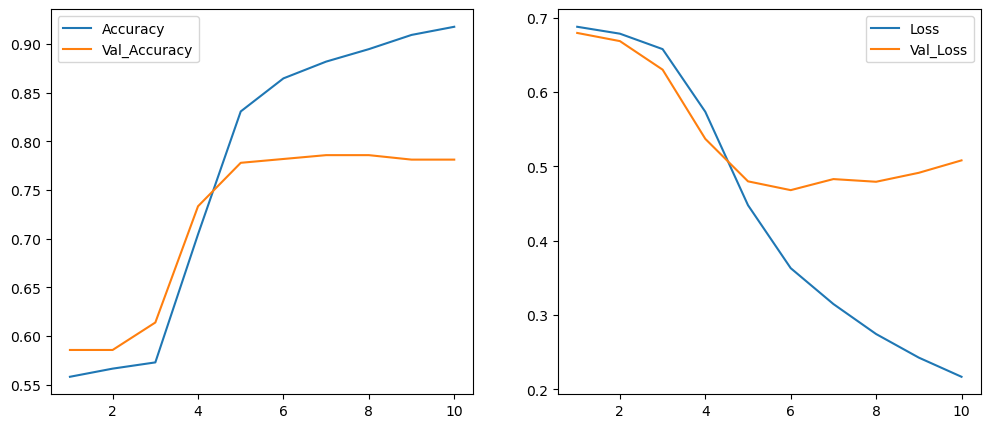

In [179]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

ax1.plot(accuracy['Epoch'],accuracy['Accuracy'])
ax1.plot(accuracy['Epoch'],accuracy['Val_Accuracy'])
ax1.legend(['Accuracy', 'Val_Accuracy'])

ax2.plot(loss['Epoch'], loss['Loss'])
ax2.plot(loss['Epoch'], loss['Val_Loss'])
ax2.legend(['Loss', 'Val_Loss'])

### Predicting the Test Dataset

Now that we have our models trained, we can use them to predict whether tweets are about a disaster or not. After importing the test dataset, it goes through the same cleaning and processing as the training dataset. In the end, we get a padded list of all the tweets. Those padded lists are fed into the prediction model to predict if the tweets in the test dataset are about disasters or not.

In [189]:
#import test file
test = pd.read_csv('https://raw.githubusercontent.com/kech3776/NLP-Disaster-Tweets/main/train.csv')
test.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [190]:
#use NLTK to clean the text and remove unwanted columns
test_clean = clean_data(test, 'text')
test_clean = test_clean.drop(columns = ['keyword', 'location'])
test_clean.head()

,id,text,target,Tokenized,SetLength
0,1,Our Deeds are the Reason of this #earthquake M...,1,"[deeds, reason, earthquake, may, allah, forgiv...",7
1,4,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]",7
2,5,All residents asked to 'shelter in place' are ...,1,"[residents, ask, shelter, place, notify, offic...",11
3,6,"13,000 people receive #wildfires evacuation or...",1,"[people, receive, wildfires, evacuation, order...",6
4,7,Just got sent this photo from Ruby #Alaska as ...,1,"[get, send, photo, ruby, alaska, smoke, wildfi...",9


In [95]:
#turn words into a vector of numbers and pad the tweets
X_test = test_clean['Tokenized'].to_numpy()
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen = 23, padding = "post", truncating = "post")

In [105]:
yhat_lstm = lstm_model.predict(X_test_padded, verbose = 1)

102/102 [==============================] - 1s 3ms/step


In [115]:
yhat_gru = gru_model.predict(X_test_padded, verbose = 1)

102/102 [==============================] - 1s 3ms/step


In [113]:
test_lstm = pd.DataFrame()
test_lstm['id'] = test['id']
#round prediction to a 1 or 0
test_lstm['target'] = list(map(lambda x: 0 if x < 0.5 else 1, yhat_lstm))

In [114]:
test_lstm.to_csv('LSTM_prediction.csv', index = False)

In [117]:
test_gru = pd.DataFrame()
test_gru['id']  = test['id']
test_gru['target'] = list(map(lambda x: 0 if x < 0.5 else 1, yhat_gru))

In [118]:
test_gru.to_csv('GRU_prediction.csv', index = False)

## Conclusion and Takeaways

After working through this mini-project, we were able to create a couple of Recurrent Neural Networks in the form of a LSMT model and a GRU model for natural language processing purposes. Towards the beginning of the project, there was considerable amount of text preprocessing. First we used NLTK libraries to clean the data. Then we used preprocessing libraries in Keras to ready the data for the neural networks. Building and tuning the hyperparameters of the neural networks came next. In building the LSTM and GRU models we modified the number of layers and multiple hyperparameters such as learning rate, dropout and recurring dropout. We even changed layers into bidirectional layers to help improve the training of the model.

In the future, I would like to try a few more different methods. For the data preprocessing, I would try to reduce the total number of unique words used. Words that may only be used once or twice could be removed from the possible word pool. I would also consider decreasing the padding of the data from the largest possible tweet to a length closer to the median or mean length of a tweet. I would also experiment with other recurrent deep learning models to see if they have increased accuracy and/or reduced loss.